# Chapter 6. The Haunted DAG & The Causal Terror

In [1]:
import warnings

import arviz as az
from causalgraphicalmodels import CausalGraphicalModel
import daft
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd

from jax import lax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro as npyro
from numpyro.contrib.autoguide import (AutoContinuousELBO,
                                       AutoLaplaceApproximation)
from numpyro.diagnostics import print_summary
import numpyro.distributions as dist
from numpyro.infer import SVI
import numpyro.optim as optim

%config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = (lambda message, category, *args, **kwargs:
                          "{}: {}\n".format(category.__name__, message))
az.style.use("arviz-darkgrid")

### Code 6.1

In [2]:
with npyro.handlers.seed(rng=1914):
    N = 200  # num grant proposals
    p = 0.1  # proportion to select
    # uncorrelated newsworthiness and trustworthiness
    nw = npyro.sample("nw", dist.Normal(), sample_shape=(N,))
    tw = npyro.sample("tw", dist.Normal(), sample_shape=(N,))
    # select top 10% of combined scores
    s = nw + tw  # total score
    q = np.quantile(s, 1 - p)  # top 10% threshold
    selected = np.where(s >= q, True, False)
onp.corrcoef(tw[selected], nw[selected])[0, 1]

-0.645340197534104

### Code 6.2

In [3]:
N = 100  # number of individuals
with npyro.handlers.seed(rng=909):
    # sim total height of each
    height = npyro.sample("height", dist.Normal(10, 2), sample_shape=(N,))
    # leg as proportion of height
    leg_prop = npyro.sample("prop", dist.Uniform(0.4, 0.5), sample_shape=(N,))
    # sim left leg as proportion + error
    leg_left = leg_prop * height + npyro.sample(
        "left_error", dist.Normal(0, 0.02), sample_shape=(N,))
    # sim right leg as proportion + error
    leg_right = leg_prop * height + npyro.sample(
        "right_error", dist.Normal(0, 0.02), sample_shape=(N,))
    # combine into data frame
    d = pd.DataFrame(
        {"height": height, "leg_left": leg_left, "leg_right": leg_right})

### Code 6.3

In [4]:
def model(leg_left, leg_right, height):
    a = npyro.sample("a", dist.Normal(10, 100))
    bl = npyro.sample("bl", dist.Normal(2, 10))
    br = npyro.sample("br", dist.Normal(2, 10))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a + bl * leg_left + br * leg_right
    npyro.sample("height", dist.Normal(mu, sigma), obs=height)

m6_1 = AutoLaplaceApproximation(model)
svi = SVI(model, m6_1, optim.Adam(0.3), AutoContinuousELBO(),
          leg_left=d.leg_left.values, leg_right=d.leg_right.values,
          height=d.height.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(2000))
p6_1 = svi.get_params(state)
post = m6_1.sample_posterior(PRNGKey(1), p6_1, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.79      0.34      0.77      0.25      1.29   1049.96      1.00
        bl      0.28      2.26      0.29     -3.37      3.90    813.42      1.00
        br      1.77      2.27      1.76     -2.03      5.30    805.90      1.00
     sigma      0.67      0.05      0.67      0.59      0.74    931.04      1.00



### Code 6.4

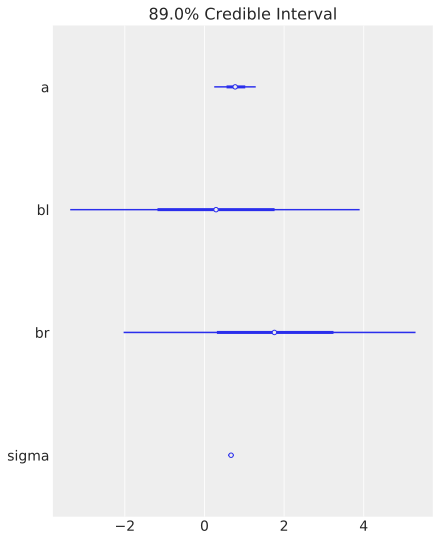

In [5]:
az.plot_forest(post, credible_interval=0.89);

### Code 6.5

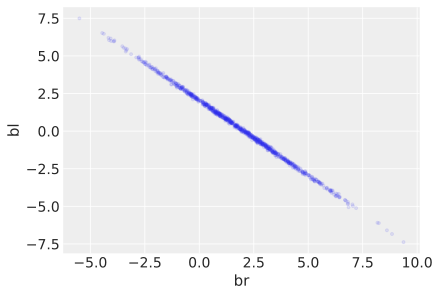

In [6]:
post = m6_1.sample_posterior(PRNGKey(1), p6_1, (1000,))
az.plot_pair(post, ["br", "bl"], plot_kwargs={"alpha": 0.1});

### Code 6.6

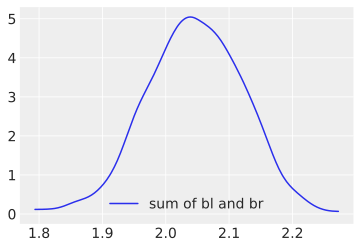

In [7]:
sum_blbr = post["bl"] + post["br"]
az.plot_kde(sum_blbr, label="sum of bl and br");

### Code 6.7

In [8]:
def model(leg_left, height):
    a = npyro.sample("a", dist.Normal(10, 100))
    bl = npyro.sample("bl", dist.Normal(2, 10))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a + bl * leg_left
    npyro.sample("height", dist.Normal(mu, sigma), obs=height)

m6_2 = AutoLaplaceApproximation(model)
svi = SVI(model, m6_2, optim.Adam(1), AutoContinuousELBO(),
          leg_left=d.leg_left.values, height=d.height.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p6_2 = svi.get_params(state)
post = m6_2.sample_posterior(PRNGKey(1), p6_2, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.83      0.35      0.84      0.25      1.35    931.50      1.00
        bl      2.02      0.08      2.02      1.91      2.15    940.42      1.00
     sigma      0.67      0.05      0.67      0.60      0.75    949.18      1.00



### Code 6.8

In [9]:
milk = pd.read_csv("../data/milk.csv", sep=";")
d = milk
d["K"] = d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())
d["F"] = d["perc.fat"].pipe(lambda x: (x - x.mean()) / x.std())
d["L"] = d["perc.lactose"].pipe(lambda x: (x - x.mean()) / x.std())

### Code 6.9

In [10]:
# kcal.per.g regressed on perc.fat
def model(F, K):
    a = npyro.sample("a", dist.Normal(0, 0.2))
    bF = npyro.sample("bF", dist.Normal(0, 0.5))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a + bF * F
    npyro.sample("K", dist.Normal(mu, sigma), obs=K)

m6_3 = AutoLaplaceApproximation(model)
svi = SVI(model, m6_3, optim.Adam(1), AutoContinuousELBO(),
          F=d.F.values, K=d.K.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p6_3 = svi.get_params(state)

# kcal.per.g regressed on perc.lactose
def model(L, K):
    a = npyro.sample("a", dist.Normal(0, 0.2))
    bL = npyro.sample("bL", dist.Normal(0, 0.5))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a + bL * L
    npyro.sample("K", dist.Normal(mu, sigma), obs=K)

m6_4 = AutoLaplaceApproximation(model)
svi = SVI(model, m6_4, optim.Adam(1), AutoContinuousELBO(),
          L=d.L.values, K=d.K.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p6_4 = svi.get_params(state)

post = m6_3.sample_posterior(PRNGKey(1), p6_3, (1000,))
print_summary(post, 0.89, False)
post = m6_4.sample_posterior(PRNGKey(1), p6_4, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.01      0.08      0.01     -0.13      0.12    931.50      1.00
        bF      0.86      0.09      0.86      0.73      1.01   1111.41      1.00
     sigma      0.46      0.06      0.46      0.37      0.57    940.36      1.00


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a     -0.26      0.13     -0.26     -0.47     -0.07    931.50      1.00
        bL     -0.85      0.10     -0.85     -1.00     -0.69    937.41      1.00
     sigma      0.51      0.11      0.50      0.36      0.69    949.96      1.00



### Code 6.10

In [11]:
def model(F, L, K):
    a = npyro.sample("a", dist.Normal(0, 0.2))
    bF = npyro.sample("bF", dist.Normal(0, 0.5))
    bL = npyro.sample("bL", dist.Normal(0, 0.5))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a + bF * F + bL * L
    npyro.sample("K", dist.Normal(mu, sigma), obs=K)

m6_5 = AutoLaplaceApproximation(model)
svi = SVI(model, m6_5, optim.Adam(1), AutoContinuousELBO(),
          F=d.F.values, L=d.L.values, K=d.K.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p6_5 = svi.get_params(state)
post = m6_5.sample_posterior(PRNGKey(1), p6_5, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a     -0.00      0.07     -0.00     -0.11      0.10   1049.96      1.00
        bF      0.25      0.19      0.25     -0.05      0.56    822.39      1.00
        bL     -0.67      0.19     -0.67     -0.98     -0.36    873.22      1.00
     sigma      0.39      0.05      0.38      0.31      0.46    963.16      1.00



### Code 6.11

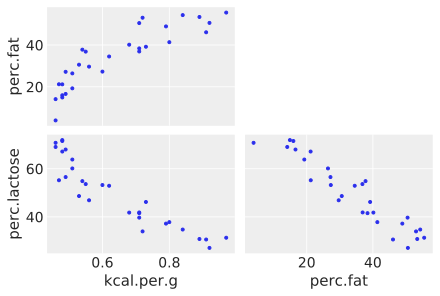

In [12]:
az.plot_pair(d[["kcal.per.g", "perc.fat", "perc.lactose"]].to_dict("list"));

### Code 6.12

In [13]:
onp.corrcoef(d["perc.fat"], d["perc.lactose"])[0, 1]

-0.9416373456839282

### Code 6.13

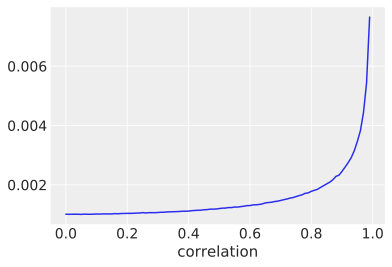

In [14]:
milk = pd.read_csv("../data/milk.csv", sep=";")
d = milk

def sim_coll(i, r=0.9):
    sd = np.sqrt((1 - r ** 2) * np.var(d["perc.fat"].values))
    x = dist.Normal(r * d["perc.fat"].values, sd).sample(PRNGKey(3 * i))

    def model(perc_fat, kcal_per_g):
        intercept = npyro.sample("intercept", dist.Normal(0, 10))
        b_perc_flat = npyro.sample("b_perc.fat", dist.Normal(0, 10))
        b_x = npyro.sample("b_x", dist.Normal(0, 10))
        sigma = npyro.sample("sigma", dist.HalfCauchy(2))
        mu = intercept + b_perc_flat * perc_fat + b_x * x
        npyro.sample("kcal.per.g", dist.Normal(mu, sigma), obs=kcal_per_g)

    m = AutoLaplaceApproximation(model)
    svi = SVI(model, m, optim=optim.Adam(0.01), loss=AutoContinuousELBO(),
              perc_fat=d["perc.fat"].values, kcal_per_g=d["kcal.per.g"].values)
    init_state = svi.init(PRNGKey(3 * i + 1))
    state = lax.fori_loop(0, 20000, lambda i, x: svi.update(x)[0], init_state)
    params = svi.get_params(state)
    samples = m.sample_posterior(PRNGKey(3 * i + 2), params, (1000,))
    vcov = np.cov(np.stack(list(samples.values()), axis=0))
    stddev = np.sqrt(np.diag(vcov))  # stddev of parameter
    return dict(zip(samples.keys(), stddev))["b_perc.fat"]

def rep_sim_coll(r=0.9, n=100):
    stddev = lax.map(lambda i: sim_coll(i, r=r), np.arange(n))
    return np.nanmean(stddev)

r_seq = np.arange(start=0, stop=1, step=0.01)
stddev = lax.map(lambda z: rep_sim_coll(r=z, n=100), r_seq)
plt.plot(r_seq, stddev)
plt.xlabel("correlation");

### Code 6.14

In [15]:
with npyro.handlers.seed(rng=71):
    # number of plants
    N = 100

    # simulate initial heights
    h0 = npyro.sample("h0", dist.Normal(10, 2), sample_shape=(N,))

    # assign treatments and simulate fungus and growth
    treatment = np.repeat(np.arange(2), repeats=N // 2)
    fungus = npyro.sample(
        "fungus", dist.Binomial(total_count=1, probs=(0.5 - treatment * 0.4)))
    h1 = h0 + npyro.sample("diff", dist.Normal(5 - 3 * fungus))

    # compose a clean data frame
    d = pd.DataFrame(
        {"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})
print_summary(dict(zip(d.columns, d.T.values)), 0.89, False)


                 mean       std    median      5.5%     94.5%     n_eff     r_hat
     fungus      0.29      0.46      0.00      0.00      1.00     49.62      1.23
         h0      9.73      1.95      9.63      7.05     13.33     80.22      0.99
         h1     13.78      2.76     14.03      9.75     18.28     52.23      1.07
  treatment      0.50      0.50      0.50      0.00      1.00      2.64       inf



### Code 6.15

In [16]:
sim_p = dist.LogNormal(0, 0.25).sample(PRNGKey(0), (int(1e4),))
print_summary({"sim_p": sim_p}, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
     sim_p      1.04      0.27      1.00      0.63      1.44   9936.32      1.00



### Code 6.16

In [17]:
def model(h0, h1):
    p = npyro.sample("p", dist.LogNormal(0, 0.25))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = h0 * p
    npyro.sample("h1", dist.Normal(mu, sigma), obs=h1)

m6_6 = AutoLaplaceApproximation(model)
svi = SVI(model, m6_6, optim.Adam(1), AutoContinuousELBO(),
          h0=d.h0.values, h1=d.h1.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p6_6 = svi.get_params(state)
post = m6_6.sample_posterior(PRNGKey(1), p6_6, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         p      1.40      0.02      1.40      1.37      1.43    994.31      1.00
     sigma      1.83      0.13      1.82      1.63      2.04   1011.70      1.00



### Code 6.17

In [18]:
def model(treatment, fungus, h0, h1):
    a = npyro.sample("a", dist.LogNormal(0, 0.2))
    bt = npyro.sample("bt", dist.Normal(0, 0.5))
    bf = npyro.sample("bf", dist.Normal(0, 0.5))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    p = a + bt * treatment + bf * fungus
    mu = h0 * p
    npyro.sample("h1", dist.Normal(mu, sigma), obs=h1)

m6_7 = AutoLaplaceApproximation(model)
svi = SVI(model, m6_7, optim.Adam(0.3), AutoContinuousELBO(),
          treatment=d.treatment.values, fungus=d.fungus.values,
          h0=d.h0.values, h1=d.h1.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p6_7 = svi.get_params(state)
post = m6_7.sample_posterior(PRNGKey(1), p6_7, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      1.48      0.02      1.48      1.44      1.51   1049.15      1.00
        bf     -0.30      0.03     -0.30     -0.35     -0.25    911.90      1.00
        bt      0.00      0.03      0.00     -0.04      0.05   1121.27      1.00
     sigma      1.21      0.08      1.22      1.07      1.33    980.18      1.00



### Code 6.18

In [19]:
def model(treatment, h0, h1):
    a = npyro.sample("a", dist.LogNormal(0, 0.2))
    bt = npyro.sample("bt", dist.Normal(0, 0.5))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    p = a + bt * treatment
    mu = h0 * p
    npyro.sample("h1", dist.Normal(mu, sigma), obs=h1)

m6_8 = AutoLaplaceApproximation(model)
svi = SVI(model, m6_8, optim.Adam(1), AutoContinuousELBO(),
          treatment=d.treatment.values, h0=d.h0.values, h1=d.h1.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p6_8 = svi.get_params(state)
post = m6_8.sample_posterior(PRNGKey(1), p6_8, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      1.33      0.02      1.33      1.29      1.37    930.83      1.00
        bt      0.14      0.03      0.13      0.09      0.20    880.03      1.00
     sigma      1.70      0.12      1.70      1.52      1.91    948.83      1.00



### Code 6.19

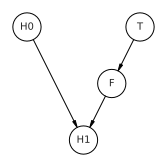

In [20]:
plant_dag = CausalGraphicalModel(
    nodes=["H0", "H1", "F", "T"],
    edges=[("H0", "H1"),
           ("F", "H1"),
           ("T", "F")])
pgm = daft.PGM()
coordinates = {"H0": (0, 0), "T": (2, 0), "F": (1.5, 1), "H1": (1, 2)}
for node in plant_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in plant_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

### Code 6.20

In [21]:
print(plant_dag.is_d_separated("T", "H1"))
print(plant_dag.is_d_separated("T", "H1", {"F"}))

False
True


### Code 6.21

In [22]:
all_independencies = plant_dag.get_all_independence_relationships()
for s in all_independencies:
    if all(t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
           for t in all_independencies if t != s):
        print(s)

('F', 'H0', set())
('H1', 'T', {'F'})
('H0', 'T', set())


### Code 6.22

In [23]:
def sim_happiness(seed=1977, N_years=1000, max_age=65, N_births=20, aom=18):
    # age existing individuals & newborns
    A = np.repeat(np.arange(1, N_years + 1), N_births)
    # sim happiness trait - never changes
    H = np.repeat(
        np.linspace(-2, 2, N_births)[None, :], N_years, 0).reshape(-1)
    # not yet married
    M = np.zeros(N_years * N_births, dtype=np.uint8)

    def update_M(i, M):
        # for each person over 17, chance get married
        married = dist.Bernoulli(logits=(H - 4)).sample(PRNGKey(seed + i))
        return np.where((A >= i) & (M == 0), married, M)

    M = lax.fori_loop(aom, max_age + 1, update_M, M)
    # mortality
    deaths = A > max_age
    A = A[~deaths]
    H = H[~deaths]
    M = M[~deaths]

    d = pd.DataFrame({"age": A, "married": M, "happiness": H})
    return d

d = sim_happiness(seed=1977, N_years=1000)
print_summary(dict(zip(d.columns, d.T.values)), 0.89, False)


                 mean       std    median      5.5%     94.5%     n_eff     r_hat
        age     33.00     18.77     33.00      1.00     58.00      2.51      2.64
  happiness      0.00      1.21      0.00     -1.79      1.79    338.78      1.00
    married      0.28      0.45      0.00      0.00      1.00     48.04      1.18



### Code 6.23

In [24]:
d2 = d[d.age > 17].copy()  # only adults
d2["A"] = (d2.age - 18) / (65 - 18)

### Code 6.24

In [25]:
d2["mid"] = d2.married

def model(mid, A, happiness):
    a = npyro.sample("a", dist.Normal(0, 1), sample_shape=(len(set(mid)),))
    bA = npyro.sample("bA", dist.Normal(0, 2))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a[mid] + bA * A
    npyro.sample("happiness", dist.Normal(mu, sigma), obs=happiness)

m6_9 = AutoLaplaceApproximation(model)
svi = SVI(model, m6_9, optim.Adam(1), AutoContinuousELBO(),
          mid=d2.mid.values, A=d2.A.values, happiness=d2.happiness.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p6_9 = svi.get_params(state)
post = m6_9.sample_posterior(PRNGKey(1), p6_9, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]     -0.20      0.06     -0.20     -0.30     -0.10   1049.96      1.00
      a[1]      1.23      0.09      1.23      1.09      1.37    898.97      1.00
        bA     -0.69      0.11     -0.69     -0.88     -0.53   1126.51      1.00
     sigma      1.02      0.02      1.02      0.98      1.05    966.00      1.00



### Code 6.25

In [26]:
def model(A, happiness):
    a = npyro.sample("a", dist.Normal(0, 1))
    bA = npyro.sample("bA", dist.Normal(0, 2))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a + bA * A
    npyro.sample("happiness", dist.Normal(mu, sigma), obs=happiness)

m6_10 = AutoLaplaceApproximation(model)
svi = SVI(model, m6_10, optim.Adam(1), AutoContinuousELBO(),
          A=d2.A.values, happiness=d2.happiness.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p6_10 = svi.get_params(state)
post = m6_10.sample_posterior(PRNGKey(1), p6_10, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.01      0.08      0.01     -0.12      0.12    931.50      1.00
        bA     -0.01      0.13     -0.01     -0.22      0.21    940.88      1.00
     sigma      1.21      0.03      1.21      1.17      1.26    949.78      1.00



### Code 6.26

In [27]:
N = 200  # number of grandparent-parent-child triads
b_GP = 1  # direct effect of G on P
b_GC = 0  # direct effect of G on C
b_PC = 1  # direct effect of P on C
b_U = 2  # direct effect of U on P and C

### Code 6.27

In [28]:
with npyro.handlers.seed(rng=1):
    U = 2 * npyro.sample("U", dist.Bernoulli(0.5), sample_shape=(N,)) - 1
    G = npyro.sample("G", dist.Normal(), sample_shape=(N,))
    P = npyro.sample("P", dist.Normal(b_GP * G + b_U * U))
    C = npyro.sample("C", dist.Normal(b_PC * P + b_GC * G + b_U * U))
    d = pd.DataFrame({"C": C, "P": P, "G": G, "U": U})

### Code 6.28

In [29]:
def model(P, G, C):
    a = npyro.sample("a", dist.Normal(0, 1))
    b_PC = npyro.sample("b_PC", dist.Normal(0, 1))
    b_GC = npyro.sample("b_GC", dist.Normal(0, 1))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a + b_PC * P + b_GC * G
    npyro.sample("C", dist.Normal(mu, sigma), obs=C)

m6_11 = AutoLaplaceApproximation(model)
svi = SVI(model, m6_11, optim.Adam(0.3), AutoContinuousELBO(),
          P=d.P.values, G=d.G.values, C=d.C.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p6_11 = svi.get_params(state)
post = m6_11.sample_posterior(PRNGKey(1), p6_11, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a     -0.08      0.10     -0.09     -0.24      0.06   1049.96      1.00
      b_GC     -0.71      0.11     -0.71     -0.89     -0.55    813.76      1.00
      b_PC      1.72      0.04      1.72      1.65      1.79    982.64      1.00
     sigma      1.39      0.07      1.39      1.28      1.49    968.54      1.00



### Code 6.29

In [30]:
def model(P, G, U, C):
    a = npyro.sample("a", dist.Normal(0, 1))
    b_PC = npyro.sample("b_PC", dist.Normal(0, 1))
    b_GC = npyro.sample("b_GC", dist.Normal(0, 1))
    b_U = npyro.sample("U", dist.Normal(0, 1))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a + b_PC * P + b_GC * G + b_U * U
    npyro.sample("C", dist.Normal(mu, sigma), obs=C)

m6_12 = AutoLaplaceApproximation(model)
svi = SVI(model, m6_12, optim.Adam(1), AutoContinuousELBO(),
          P=d.P.values, G=d.G.values, U=d.U.values, C=d.C.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(2000))
p6_12 = svi.get_params(state)
post = m6_12.sample_posterior(PRNGKey(1), p6_12, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         U      1.87      0.17      1.88      1.59      2.11   1009.20      1.00
         a     -0.06      0.08     -0.05     -0.18      0.07    766.03      1.00
      b_GC      0.01      0.10      0.01     -0.15      0.17   1031.98      1.00
      b_PC      0.99      0.07      0.99      0.88      1.11   1106.62      1.00
     sigma      1.08      0.05      1.08      0.99      1.16    797.58      1.00



### Code 6.30

In [31]:
dag_6_1 = CausalGraphicalModel(
    nodes=["X", "Y", "C", "U", "B", "A"],
    edges=[("X", "Y"), ("C", "Y"),
           ("U", "X"), ("U", "B"),
           ("A", "U"), ("A", "C"),
           ("U", "B"), ("C", "B")])
all_adjustment_sets = dag_6_1.get_all_backdoor_adjustment_sets("X", "Y")
for s in all_adjustment_sets:
    if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
        print(s)

frozenset({'C'})
frozenset({'U'})
frozenset({'A'})


### Code 6.31

In [32]:
dag_6_2 = CausalGraphicalModel(
    nodes=["S", "A", "D", "M", "W"],
    edges=[("S", "A"), ("A", "D"),
           ("S", "M"), ("M", "D"),
           ("S", "W"), ("W", "D"),
           ("A", "M")])
all_adjustment_sets = dag_6_2.get_all_backdoor_adjustment_sets("W", "D")
for s in all_adjustment_sets:
    if all(not t.issubset(s)for t in all_adjustment_sets if t != s):
        print(s)

frozenset({'M', 'A'})
frozenset({'S'})


### Code 6.32

In [33]:
all_independencies = dag_6_2.get_all_independence_relationships()
for s in all_independencies:
    if all(t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
           for t in all_independencies if t != s):
        print(s)

('W', 'A', {'S'})
('W', 'M', {'S'})
('S', 'D', {'W', 'M', 'A'})
